# 1. Neural-Networks

In [1]:
import numpy as np
import scipy.io as sio
import display_data as dd
import matplotlib.pyplot as plt

In [2]:
data = sio.loadmat('ex4data1.mat')
X_org = data['X']
y_org = data['y']
X = np.insert(X_org,0,1,axis=1)
X.shape ,y_org.shape

((5000, 401), (5000, 1))

## 1.1 Visualizing the data

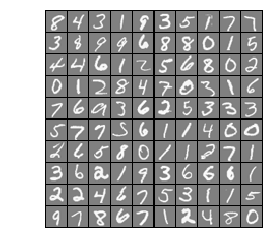

In [3]:
dd.plot_100_image(X_org)

## 1.2 Feedforward and cost function
### 1.2.1 Expand y

In [4]:
def expand_y(y):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(sparse=False,categories='auto')
    y_onehot = encoder.fit_transform(y)
    return y_onehot
y = expand_y(y_org)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### 1.2.2 Serialize $\theta$

In [5]:
data = sio.loadmat('ex4weights.mat')
theta1,theta2 = data['Theta1'],data['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [6]:
def serialize(theta1,theta2):
    return np.append(theta1,theta2)

theta_serialize = serialize(theta1,theta2)
theta_serialize.shape

(10285,)

### 1.2.3 Deserialize $\theta$

In [7]:
def deserialize(theta):
    theta1 = theta[:25*401].reshape(25,401)
    theta2 = theta[25*401:].reshape(10,26)
    return theta1,theta2
theta1,theta2 = deserialize(theta_serialize)
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 1.2.4 Feedforward

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
def feed_forward(theta_s,X):
    theta1,theta2 = deserialize(theta_s)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,1,axis=1)
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h

### 1.2.5 cost function

In [10]:
def cost(theta_s,X,y):
    m = X.shape[0]
    _,_,_,_,h = feed_forward(theta_s,X)
    cost = np.sum(-y*np.log(h)-(1-y)*np.log(1-h))/m
    return cost

In [11]:
cost(theta_serialize,X,y)

0.2876291651613189

## 1.3 Regularized cost function

In [12]:
def reg_cost(theta_s,X,y,lmd):
    m = X.shape[0]
    theta1, theta2 = deserialize(theta_s)
    theta1, theta2 = theta1[:,1:],theta2[:,1:]
    reg = (lmd/(2*m)) * ( np.sum(np.square(theta1)) + np.sum(np.square(theta2)) )
    return reg + cost(theta_s,X,y)

In [13]:
reg_cost(theta_serialize,X,y,1)

0.38376985909092365

# 2. Backpropagation
## 2.1 Sigmoid gradient

In [14]:
def sigmoid_gradient(z):
    a = sigmoid(z)
    return a*(1-a)

## 2.2 Random initialization
One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range [$-\epsilon_{init}$ , $\epsilon_{init}$ ].<br>
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the 
network. A good choice of $\epsilon_{init}$ is $\epsilon_{init}$ = $\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$, where $L_{in}$ = $s_l$ and $L_{out}$ = $s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

In [15]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

## 2.3 Backpropagation

In [27]:
def gradient(theta_s,X,y):
    m = X.shape[0]
    theta1,theta2 = deserialize(theta_s)
    a1,z2,a2,z3,h = feed_forward(theta_s,X)
    d3 = h - y            #(5000,10)
    d2 = d3 @ theta2[:,1:] * sigmoid_gradient(z2) #(5000,25)
    D2 = (d3.T @ a2)/m    #(10,26)
    D1 = (d2.T @ a1)/m    #(25,401)
    return serialize(D1,D2)
    

In [28]:
def reg_gradient(theta_s,X,y,lmd):
    m = X.shape[0]
    D1,D2 = deserialize(gradient(theta_s,X,y))
    theta1,theta2 = deserialize(theta_s)
    D1[:,1:] = D1[:,1:] + theta1[:,1:]*lmd/m
    D2[:,1:] = D2[:,1:] + theta2[:,1:]*lmd/m
    return serialize(D1,D2)

## 2.4 Learning parameters

In [43]:
import scipy.optimize as opt

def nn_training(X,y,lmd):
    init_theta = random_init(10285)
    res = opt.minimize(fun=reg_cost,
                      x0=init_theta,
                      args=(X,y,lmd),
                      method='TNC',
                      jac=reg_gradient,
                      options={'maxiter':400})
    return res
    

In [133]:
res = nn_training(X,y,1)

In [141]:
_,_,_,_,h = feed_forward(res.x,X)

In [142]:
from sklearn.metrics import classification_report#这个包是评价报告
y_pred = np.argmax(h,1)+1
print(classification_report(y_org,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      0.99      0.99       500
           4       1.00      0.99      0.99       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      1.00      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      1.00       500

   micro avg       1.00      1.00      1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



## 2.5 Visualizing the hidden layer

In [143]:
def plot_hidden1_layer(theta):
    t1,t2 = deserialize(theta)
    hidden_layer = t1[:,1:]
    fig,ax = plt.subplots(ncols=5,nrows=5,figsize=(8,8),sharex=True,sharey=True)
    for r in range(5):
        for c in range(5):
            ax[r,c].imshow(hidden_layer[5*r+c].reshape(20,20).T,cmap='gray_r')
    
    plt.xticks([])
    plt.yticks([])
    plt.show

In [144]:
def plot_hidden2_layer(theta):
    t1,t2 = deserialize(theta)
    hidden_layer = t2[:,1:]
    fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(8,4),sharex=True,sharey=True)
    for r in range(2):
        for c in range(5):
            ax[r,c].imshow(hidden_layer[2*r+c].reshape(5,5).T,cmap='gray_r')
    
    plt.xticks([])
    plt.yticks([])
    plt.show

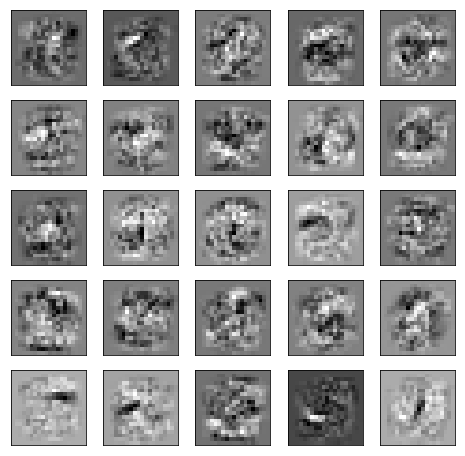

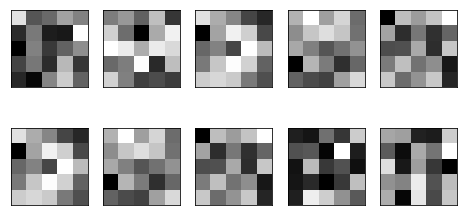

In [145]:
plot_hidden1_layer(res.x)
plot_hidden2_layer(res.x)